In [2]:
%pip install kagglehub

  Using cached kagglehub-0.3.6-py3-none-any.whl.metadata (30 kB)
Using cached kagglehub-0.3.6-py3-none-any.whl (51 kB)
Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import os
import shutil

move_folder = './data'
dataset_path = kagglehub.dataset_download("ealaxi/paysim1")

# Moving files to target folder
if not os.path.exists(move_folder):
    os.makedirs(move_folder)

for file in os.listdir(dataset_path):
    src_path = os.path.join(dataset_path, file)
    dst_path = os.path.join(move_folder, file)
    shutil.move(src_path, dst_path)

print(f"Files moved to: {move_folder}")

# Load data
df = pd.read_csv('./data/PS_20174392719_1491204439457_log.csv', nrows=10000)

# Initial exploration
df.head()
df.info()
df.describe(include='all')

# Count fraud cases
df['isFraud'].value_counts()

100%|██████████| 178M/178M [00:16<00:00, 11.2MB/s] 

Extracting files...


Files moved to: ./data
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            10000 non-null  int64  
 1   type            10000 non-null  object 
 2   amount          10000 non-null  float64
 3   nameOrig        10000 non-null  object 
 4   oldbalanceOrg   10000 non-null  float64
 5   newbalanceOrig  10000 non-null  float64
 6   nameDest        10000 non-null  object 
 7   oldbalanceDest  10000 non-null  float64
 8   newbalanceDest  10000 non-null  float64
 9   isFraud         10000 non-null  int64  
 10  isFlaggedFraud  10000 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 859.5+ KB


isFraud
0    9932
1      68
Name: count, dtype: int64

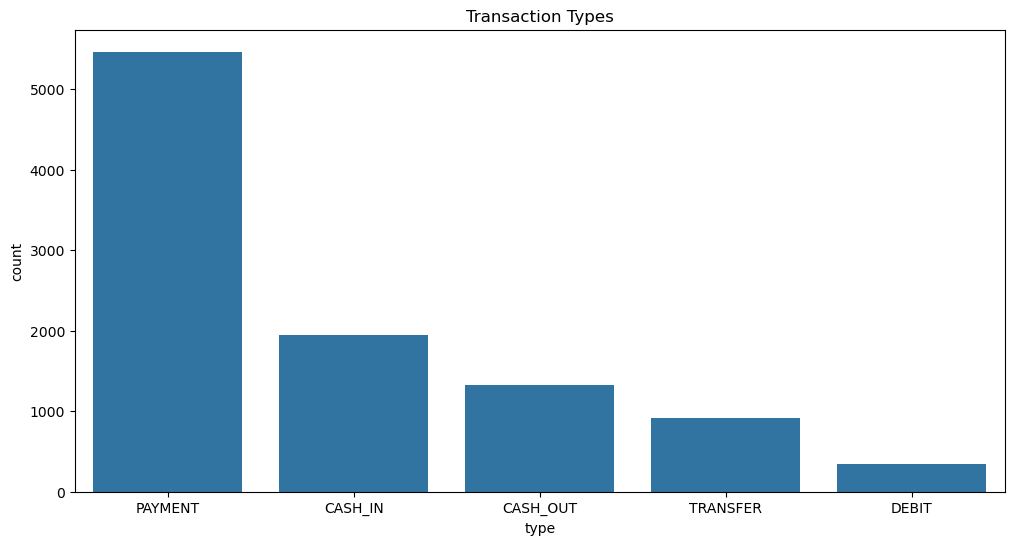

In [4]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='type', order=df['type'].value_counts().index)
plt.title('Transaction Types')
plt.show()

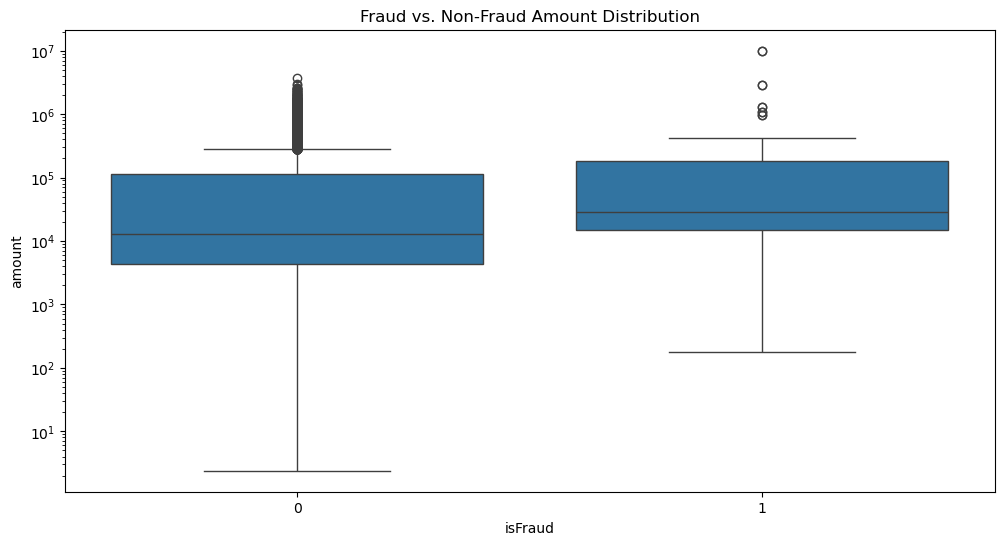

In [5]:


plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='isFraud', y='amount')
plt.title('Fraud vs. Non-Fraud Amount Distribution')
plt.yscale('log')
plt.show()

C:\Users\boobb\AppData\Local\Temp\ipykernel_3028\3421907590.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['amount'], df['accountDiff']], labels=['amount', 'account_difference'])


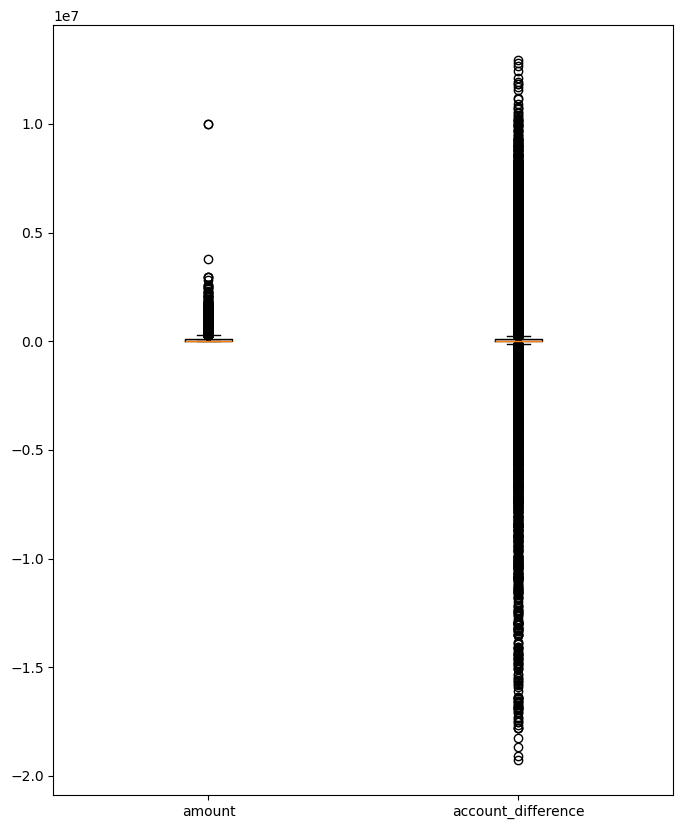

In [6]:
# Feature engineering
df['isPayment'] = [1 if (x == 'PAYMENT' or x == 'DEBIT') else 0 for x in df['type']]
df['isMovement'] = [1 if (x == 'CASH_OUT' or x == 'TRANSFER') else 0 for x in df['type']]
df['accountDiff'] = df['oldbalanceOrg'] - df['oldbalanceDest']

# Check for outliers
plt.figure(figsize=(8, 10))
plt.boxplot([df['amount'], df['accountDiff']], labels=['amount', 'account_difference'])
plt.show()

In [8]:
# Remove outliers
df = df[df['amount'] < 5000000]

# Define features and target
X = df[['amount', 'isPayment', 'isMovement', 'accountDiff']]
y = df['isFraud']

# Scale features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

# Apply Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1)
gb_clf.fit(X_train, y_train)

summary = df.describe(include='all')  # Include all columns (numeric and non-numeric)

# Print the summary
print(summary)

# Predict and evaluate
y_predict = gb_clf.predict(X_test)

               step     type        amount     nameOrig  oldbalanceOrg  \
count   9998.000000     9998  9.998000e+03         9998   9.998000e+03   
unique          NaN        5           NaN         9998            NaN   
top             NaN  PAYMENT           NaN  C1231006815            NaN   
freq            NaN     5465           NaN            1            NaN   
mean       4.178936      NaN  1.015670e+05          NaN   8.918184e+05   
std        2.480067      NaN  2.265744e+05          NaN   2.130555e+06   
min        1.000000      NaN  2.390000e+00          NaN   0.000000e+00   
25%        1.000000      NaN  4.397430e+03          NaN   1.270625e+02   
50%        5.000000      NaN  1.284801e+04          NaN   2.136906e+04   
75%        7.000000      NaN  1.143356e+05          NaN   1.776300e+05   
max        7.000000      NaN  3.776389e+06          NaN   1.292938e+07   

        newbalanceOrig    nameDest  oldbalanceDest  newbalanceDest  \
count     9.998000e+03        9998    9.9

Confusion Matrix:
[[2980   11]
 [   5    4]]


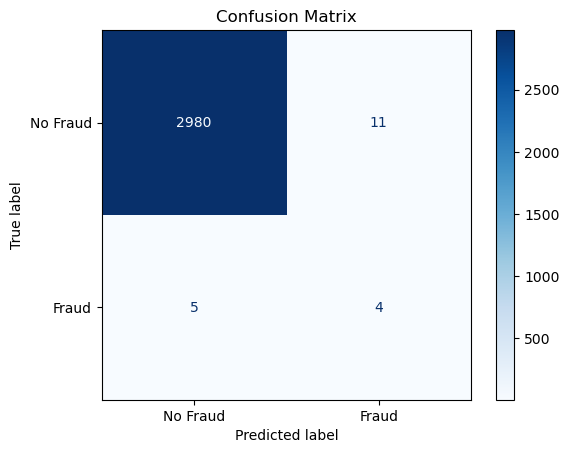

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2991
           1       0.27      0.44      0.33         9

    accuracy                           0.99      3000
   macro avg       0.63      0.72      0.67      3000
weighted avg       1.00      0.99      1.00      3000



In [9]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['No Fraud', 'Fraud'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


# Classification report
print("Classification Report:")
print(classification_report(y_test, y_predict))

Feature Importance:
       Feature  Importance
3  accountDiff    0.600567
0       amount    0.329351
2   isMovement    0.067562
1    isPayment    0.002520


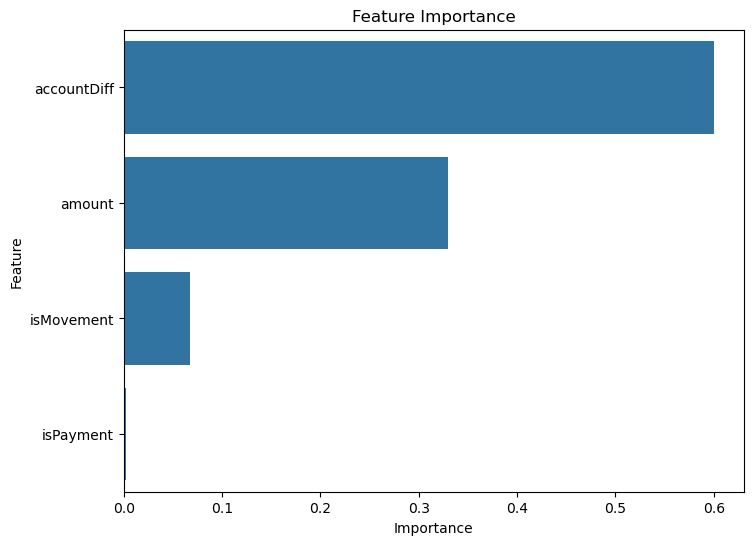

In [10]:


# Feature importance
feature_importance = pd.DataFrame(
    zip(['amount', 'isPayment', 'isMovement', 'accountDiff'], gb_clf.feature_importances_), 
    columns=['Feature', 'Importance']
).sort_values(by='Importance', ascending=False)
print("Feature Importance:")
print(feature_importance)

# Visualize feature importance
plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance)
plt.title('Feature Importance')
plt.show()

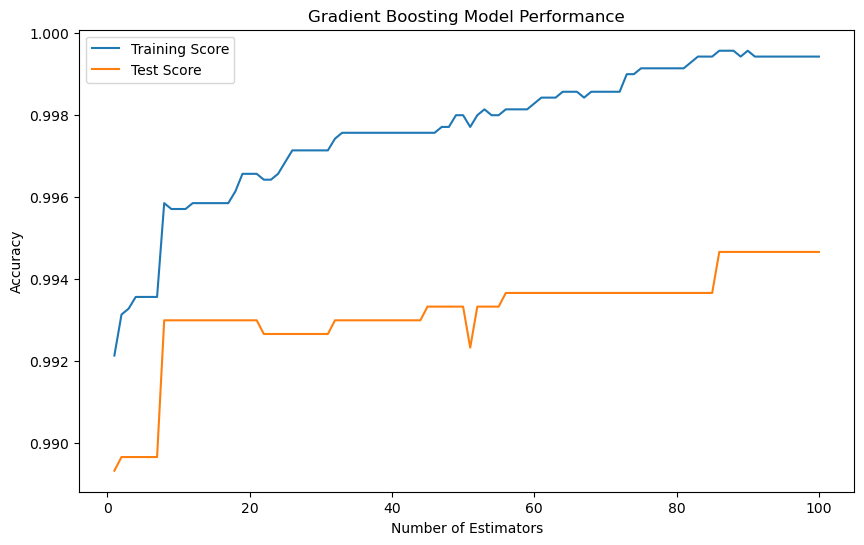

In [11]:

# Line graph of Gradient Boosting model results
n_estimators = range(1, 101)
train_scores = []
test_scores = []

for n in n_estimators:
    temp_gb_clf = GradientBoostingClassifier(n_estimators=n, learning_rate=0.1, max_depth=3, random_state=1)
    temp_gb_clf.fit(X_train, y_train)
    train_scores.append(temp_gb_clf.score(X_train, y_train))
    test_scores.append(temp_gb_clf.score(X_test, y_test))

plt.figure(figsize=(10, 6))
plt.plot(n_estimators, train_scores, label='Training Score')
plt.plot(n_estimators, test_scores, label='Test Score')
plt.xlabel('Number of Estimators')
plt.ylabel('Accuracy')
plt.title('Gradient Boosting Model Performance')
plt.legend()
plt.show()

